# Treasury Issuance Model
This code replicates Belton et al up to Fig 13 and can be used to extend the analysis to FRNs and TIPSs.  
Instructions: please edit the "Settings" section (and only that section) after the "Imports" section. The code is organized as follows:
* I) Imports
* II) Settings (user may edit here)
* III) Macro and Fiscal Block
* IV) Rates Block
* V) Debt Block
* VI) Baseline issuance strategy simulation (Belton et al Fig 4)
* VII) Strategies' Performance Evaluation, with optional Supply Effects
    1. Static Single-Security Issuance Strategies (Belton et al Fig 5)
    2. Static Kernel Issuance Strategies (Belton et al Fig 6)
    3. Static Optimization (Belton et al Fig 7, changed for optimal frontier)
    4. Dynamic Strategy (Belton et al Fig 13)

## I) Imports
Import needed libraries

In [1]:
from time import time; tic=time()               # To measure code speed.  
import numpy as np, pandas as pd, matplotlib.pyplot as plt, warnings
from tqdm.notebook import tqdm, trange          # To show progress bars in Jupyter. 
try:
    import pandas_datareader
except: 
    %pip install pandas-datareader
warnings.simplefilter('ignore', np.RankWarning) # Suppress warnings triggered by saturating degrees of freedom for fitting polynomials.

Any plot will be displayed inline in this Jupyter notebook, directly below the code cell that produce it

In [2]:
%matplotlib inline  

Import all functions from our library.
Also, try to use the gpu if Cupy is available. NOTE: If Cupy is available, xp. will be set to refer to Numpy (usual role of np.) or Cupy (usual role of cp.) 

In [3]:
%run ../bin/sim_lib

Cupy is installed, GPU will be used


## II) Settings
Please edit the dictionary entries with your settings if you wish to change them! Initialize the dictionary:

In [4]:
D_Setup = {}  # Dictionary is more user-friendly than a class. 

Do you wish to replicate Belton et al? If True, all other settings will be automatically overwritten later so you don't need to edit anything else. 

In [5]:
D_Setup["ReplicateBelton"] = False

All other settings, relevant only if ReplicateBelton = False. RIghy now, set to replicate TBAC slides for TIPS.

In [6]:
# start_year : int
#     The year the forward simulation begins (default is 2017)
D_Setup["start_year"] = 2017

# start_quarter : int
#     The quarter the forward simulation begins (default is Q4)
D_Setup["start_quarter"] = 4

# Securities : numpy.array
#     2 rows x N columns : 
#     1st row specifies security type (Nominal=0, TIPS=1, FRN=2),
#     2nd row specifies security tenor, in years (from 0.25 to n_exp_horizon//4, always use multiples of 0.25). 
#     Maximum tenor is 50.
D_Setup["Securities"] = np.array([[0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 1 , 1 , 1 , 1 , 2 , 2 ],  
                                  [1 , 2 , 3 , 5 , 7 , 10, 20, 30, 50, 2 , 5 , 10, 30, 2 , 5 ]]) 

# Kernel1_Baseline : numpy or cupy array (use xp.) of float32 
#     N x 1 column vector of baseline issuance shares. As many columns as Securities. Sum to 1.
D_Setup["Kernel1_Baseline"] = xp.reshape(xp.array([0.475,  0.11,  0.09, 0.115, 0.085,  0.08,   0.0, 0.045,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0], dtype= xp.float32), (-1,1)) 
   
# Other Kernels : numpy or cupy arrays of float32
#     N x 1 column vectors, K of them. Kernels shift issuance shares away from Baseline. For each vector, deviations must sum to zero.
D_Setup["Kernel2_Bills"]    = xp.reshape(xp.array([ 1.00, -0.21, -0.17, -0.22, -0.16, -0.15,   0.0, -0.09,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0], dtype= xp.float32), (-1,1)) 
D_Setup["Kernel3_Belly"]    = xp.reshape(xp.array([-0.25,  0.25,  1.00,  0.50, -0.50, -0.75,   0.0, -0.25,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0], dtype= xp.float32), (-1,1))    
D_Setup["Kernel4_Bonds"]    = xp.reshape(xp.array([ 0.00, -0.41, -0.33, -0.41, -0.10,  0.25,   0.0,  1.00,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0], dtype= xp.float32), (-1,1)) 
D_Setup["Kernel5_Tips"]     = xp.reshape(xp.array([-0.20, -0.15, -0.15, -0.15, -0.15, -0.10,   0.0, -0.10,  0.25,  0.25,  0.25,  0.25,   0.0,   0.0,   0.0], dtype= xp.float32), (-1,1)) 

# KernelNames: list
#     1 x K list of exact names of all other Kernels specified above, except baseline. Case sensitive. 
D_Setup["L_KernelNames"]    = ["Kernel2_Bills","Kernel3_Belly","Kernel4_Bonds","Kernel5_Tips"]

# KernelBounds: list of lists of two float32
#     K pairs of lower and upper bound for weights of other Kernels, except baseline, to consider when mixing them in non-optimized mixes. 
D_Setup["L_KernelBounds"]   = [[-0.4,0.5],[-0.08,0.1],[0.00,0.25],[0.00,0.25]]  

# KernelLoads: numpy or cupy Kx4 matrix of float32
#     Used only for examle of dynamic strategy. 
#     For each Kernel other than baseline, enter a row of the matrix. Columns are (non-normalized) loadings of kernels to Constant and Macro Economic Variables (2y Real Rate, 10y Real Rate, Deficit/GDP)
D_Setup["CoeffstoConst_and_MEVs"] =  xp.array([[-279.4 , 255.2, 418.1, -0.6],  # (Non normalized) betas of K2 to Constant and MEVs
                                               [   70.6,  -6.2,  70.3,  0.3],  # (Non normalized) betas of K3 to Constant and MEVs
                                               [  -42.3,  25.0,  -5.9, -0.1],  # (Non normalized) betas of K4 to Constant and MEVs
                                               [    0.0,   0.0,   0.0,  0.0]], dtype= xp.float32) # (Non normalized) betas of K5 to Constant and MEVs

# CBO_weight : float
#     How much to adjust primary deficit mean towards CBO projection, explained in the next entry (default is 1.0)
D_Setup["CBO_weight"] = 1.0

# CBO_projection : numpy or cupy array of float32
#     Vector up to length 10 with path of CBO-projected deficit for first 10 years after start date. 
#     Mean of deficits is adjusted towards this(these) number(s) for the first 10 years. If less than 10 numbers are provided, last number is used till year 10.   
#     then the effect tapers out by year 15. Please refer to Excel files for 10-Year Budget Projection at https://www.cbo.gov/data/budget-economic-data#3. 
D_Setup["CBO_projection"] = xp.array([ -2.45], dtype= xp.float32),

# No_TIPS_FRN : bool
#     If True, TIPS and FRNs are not included in initial outstanding debt profiles
D_Setup["No_TIPS_FRN"] = False

# n_period : int
#     Number of simulation time steps in quarters.
D_Setup["n_period"] = 80

# n_simula : int
#     Number of simulation paths. If cupy is used, values above 10000 may create GPU memory issues on GPUs with 
#     3.5gb of free space, with 80 periods of time.
D_Setup["n_simula"] = 3000

# n_exp_horizon : int
#     Includes current quarter zero (quarter just ended at current end of quarter date) 
#     and 50y x 4 = 200 quarters forward.
D_Setup["n_exp_horizon"] = 201

# use10y5yslope : bool
#     If False, extrapolates Term premia using 10y-2y slope (as in the paper) rather than the 10y-5y slope
D_Setup["use10y5yslope"] = True

# use_convadj : bool
#     If True, convexity adjustment is used to extrapolate ZCB Term Premia, 
#     which are then added to expectational component to derive ZCB rates, which are finally mapped to par rates. 
#     If False, convexity adjustment is not used to extrapolate term premia.
D_Setup["use_convadj"] = True

# replicateBeltonTP : bool
#     If True, a shift in par rates is implemented, accounting for the fact that par rates of Belton et al 
#     rely on a differet implementation of convexity adjustment. 
#     The shifts are set to match Belton et al par rates when other parameters are set for 
#     replication (by ReplicateBelton=True).
D_Setup["replicateBeltonTP"] = True

# ELB : float
#     Effective lower bound for FFR is 0.125% in Belton et al
D_Setup["ELB"] = 0.125

# QuartersperCoup : int
#     Select 1 for quarterly coupon payments, 2 for semiannual coupon payments. 
D_Setup["QuartersperCoup"] = 2

# estimate_not_assume : bool
#     If True: Estimates Coefficients for ACM Term Premia interpolation between 2y and 10y and then 
#     extrapolates w/conv adj out to 50y (rather than using assumed coefficients out to 50y).
#     If False: Use some specified betas to derive TP out to 50y from TP10 and TP2. These betas can be specified in the function
#     
D_Setup["estimate_not_assume"] = True

# Supply_Effects : bool
#     If True: For simulations with strategies other than Baseline, use difference from Baseline Ten Year Equivalent Nominal Debt / GDP to compute Supply Effects (6 bps on nominal bonds per 1% difference, scaled by duration w.r.t. 10y bond)
#     If False: do not use supply effects (always left at zero)
D_Setup["Supply_Effects"] = True

# L_ParNam : List of parameter names (DO NOT MODIFY!)
# V_ParSrt : Numpy array of parameters value (MODIFY WITH CARE! Defaults to values from Belton et al. Any changes may have dramatic consequences, be careful. For instance, model may become non-stationary.)
D_Setup["L_ParNam"] =         ['rhoU1','betaUR','rhoU2','rhoZ1','betaPU','rhoP1','rhoP2','betaFTay','rhoF1','rhoEpsCPI','rhoEpsPRI','rhoEpsTP10','rhoEpsTP2','alphaZ','betaPPE2pct', 'sigmaU',  'sigmaG',  'sigmaZ' , 'sigmaP',  'sigmaNuCPI',  'sigmaNuPRI',  'sigmaNuTP10',  'sigmaNuTP2','ATP10', 'ATP2','alphaPRI', 'betaTP10U', 'BTP2U','betaTP10TP2','betaPRIU'] 
D_Setup["V_ParSrt"] = np.array([  1.57,  0.028 ,  -0.62,  0.917,  -0.133,   0.58,   0.26,      0.15,   0.85,      0.295,       0.92,        0.73,      0.63,(1-0.917)*(-0.5),0.16*2,     0.24,    0.0624,      0.018,     0.79,          1.70,          0.35,           0.41,          0.09,   0.51,  -0.05,      0.34,       0.207,-0.014+0.42*0.207,0.42,     -1.5 ])

### Change Settings to values replicating Belton et al, if asked
This function checks if user asked for settings replicating Belton et al., and in this case, overwrites the settings.

In [7]:
F_Settings_to_Belton(D_Setup)

Settings left to user-defined values


### Prepare Kernel Matrix

In [8]:
D_Setup["M_Kernels"] = D_Setup["Kernel1_Baseline"]
for name in D_Setup["L_KernelNames"]:
    D_Setup["M_Kernels"] = xp.concatenate((D_Setup["M_Kernels"], D_Setup[name]), axis=1)

## III) Macro and Fiscal Block 
Creates functions to simulate states: UGAP, G, Z, PI, FFR (macro states, and their lags); EpsCPI, EpsTP10, EpsTP2, EPsPRI (AR1 resudual states)
and functions to derive observables from states including TP10, TP2, PRI, CPI.
1. F_InitStates    : creates initial states values from the initial date
2. F_BeltonMatrices: creates the matrices and vectors used for transition and observation equation from the parameters
3. F_SimSta        : creates the state variables dynamics from simulating the transition equation starting at the initial states
4. F_SimObs        : creates the observable vars dynamics from simulated states

### 1. Set Initial States at t=0
Initialize the model states (and GDP level) for an arbitrary initial year and quarter.

In [9]:
V_StaSrt, Init_GDP = F_InitStates(D_Setup)

UGAP      -0.500000
G          2.192130
Z         -1.275219
PI         2.000000
FFR        1.300000
lagUGAP   -0.500000
lagG       2.192130
lagZ      -1.275219
lagPI      2.000000
lagFFR     1.300000
EpsCPI     0.000000
EpsPRI     0.000000
EpsTP10   -0.532537
EpsTP2    -0.138919
dtype: float64
Init_GDP 19882


In [10]:
#V_StaSrt, Init_GDP = np.array([-0.5,1.5,-1,1.8, 2   ,-0.5,1.5,-1,1.8 ,2   ,0,0,-0.25,0]), 19882

### 2. Set up matrices of state space model
Belton et al model is a linear state space model, up to the ZLB non-linearity, which is tackled separately when the transition equation is computed. 

In [11]:
ModelMats = F_BeltonMatrices(D_Setup["V_ParSrt"])

### 3. Transition Equation, for Macro Block states and AR1 residuals
This function simulates the dynamic of the state variables.

In [12]:
A_SimSta = F_SimSta(D_Setup["n_period"], D_Setup["n_simula"], V_StaSrt, ModelMats, D_Setup["ELB"])

### 4. Observation Equation, for PRI, CPI, TP10, TP2
Also returns UGAP, PI, FFR (already generated by SimSta).

In [13]:
A_SimObs = F_SimObs(A_SimSta, ModelMats, D_Setup["CBO_projection"], D_Setup["CBO_weight"])

## IV) Rates Block
F_SimRat does the rates block, calling the functions presented below. Its output are paths for Nominal, TIPS and FRNs rates.  
1. MakeFFPaths3: creates paths for average expected future FFR and CPI by making secondary simulations  
2. F_addFRP: creates FRN rates by adding the fixed term premia to 3M expected FFR. 
3. MakeTPPaths2: creates nominal rates by adding term premia to expected FFR. Uses the observables TP10, TP2 and the functons below:  
    1. MakeCoeffTP2_TP10: estimates coefficients to interpolate term premia between TP2 and TP10 from TP2 and TP10
    1. Alternative: AssumeCoeffTP2_TP10 assumes coefficients to inter/extrapolate between TP2 and TP50 from TP2 and TP10.  
    2. Extrap_TP0_TP2_2: Extrapolates term premia between tenor 2y and 0y, tapering down TP2. 
    3. Interp_TP2_TP10: Interpolates term premia between TP2 and TP10 from TP2 and TP10 using estimated coefficients. If coefficients are assumed, than also creates TP out to 50y
    4. Extrap_TP10_TP50_2: used only if coefficients were not assumed. It extrapolates term premia by duration, adjusting for convxity. Since convexity adjustments are different from Belton et al., a correction will need to be made later if ReplicateBeltonTP=True
4. F_MakeIRP: creates inflation risk premia from real rate gaps and TP10, TP5. This is then subtracted from Nominal rates to get (ExpNom + TP) - IRP. Subtracting also Expected CPI gives (ExpNom - ExpCPI + TP) - IRP
5. F_addLRP: adds liquidity risk premia to the above, giving TIPS, because ExpNom - ExpInf + TP - IRP + LRP  = (ExpNom-ExpINF) + (TP - IRP - FRP ) + FRP + LRP =  R + RRP + FRP + LRP = TIPS
6. MakeCoupRates: Converts the ZCB curves (Nominal and Tips) into a par curve.
7. Corrections to Nominal par curve: 
    1. 8bps correction to Nominal tenors below 1y for the Bill-Fed Fund basis. 
    2. Make_on_run: adjusts par rates to account for ACM premia being off the run, while issuance is on the run.
    
Note: after 3., 4., 6. and 7., F_SimRat also calls F_PlotRates2 to plot the Nominal and Tips (both Zero and Par) curves, averaged across simulations.The plots show the expectational part and term premium part for both curves.

### 1. Get paths of expectations for average future Fed Funds and CPI

Illustrate function use (actual use will be in F_SimRat):

In [14]:
A_FFPaths= xp.empty(( A_SimSta.shape[0],D_Setup["n_exp_horizon"],A_SimSta.shape[2] ), dtype=xp.float32); 
A_CPIPaths= xp.empty(( A_SimSta.shape[0],30*4+1,A_SimSta.shape[2] ), dtype=xp.float32)
MakeFFPaths3(A_SimSta, ModelMats, A_FFPaths, A_CPIPaths)

  0%|          | 0/200 [00:00<?, ?it/s]

### 2. Add Fixed Term Premium to get FRN rates.

### 3. Term Premium
The function MakeTPPaths2 will be introduced after we illustrate the functions A. - G. below, which  MakeTPPaths2 uses.

#### A. Estimate coefficients for interpolation of TP between TP2, TP10

,Intercept,ACMTP02,ACMTP10
tenor,,,
2.00,-0.00,1.00,0.00
2.25,-0.01,0.97,0.05
2.50,-0.02,0.93,0.10
2.75,-0.02,0.88,0.15
3.00,-0.03,0.83,0.20


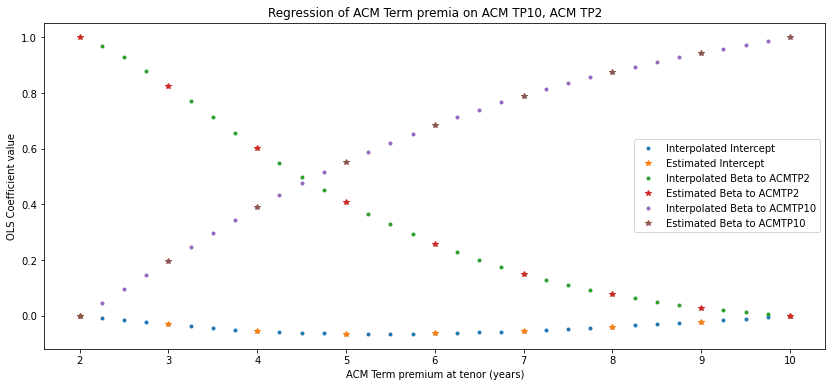

In [15]:
CoeffTP2_TP10 = MakeCoeffTP2_TP10(plot_coeff=True)
CoeffTP2_TP10.head().round(2)

#### B. Alternative: assume coefficient for interpolation and extrapolation of TP from TP2, TP10.

,Intercept,ACMTP02,ACMTP10
tenor,,,
2.00,0.0,1.00,0.00
2.25,0.0,0.96,0.05
2.50,0.0,0.92,0.09
2.75,0.0,0.89,0.14
3.00,0.0,0.85,0.18


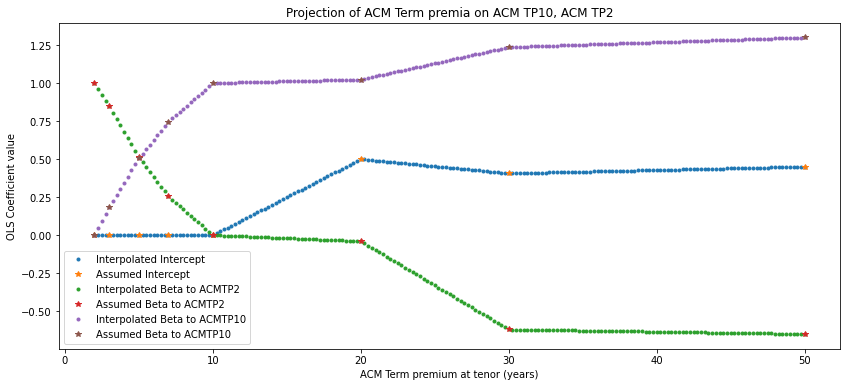

In [16]:
AssumeCoeffTP2_TP10(plot_coeff=True).head().round(2)

#### C. Extrpolate TP between 0y and 2y 

#### D. Interpolate TP between 2y and 10y (also extrapolates up to 50y if assumed coeffcients are passed)

#### E. Extrapolate TP from 10y to 50y (used by F_SimRate only when coefficients not assumed)

Illustrate Convexity Adjustments:

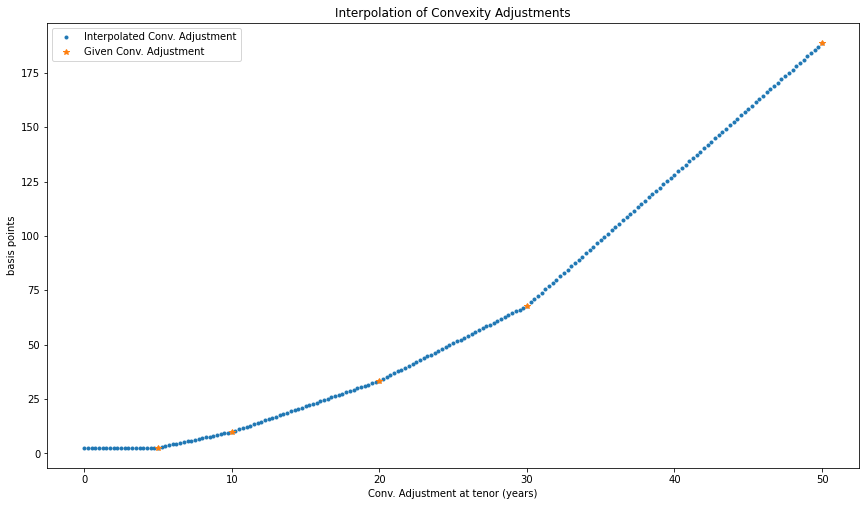

In [17]:
Tenor_y  = np.array([    5,    10,    20,    30,    50])
ConAdj_y = np.array([  2.7,   9.9,  33.4,  67.9, 188.6], dtype=np.float32)/100   
Tenor_q  = np.reshape(np.arange(0,50.25,0.25, dtype=np.float32), (-1,1))
ConAdj_q = np.interp(Tenor_q, Tenor_y, ConAdj_y)
fig1 = plt.figure(figsize=[16/1.1, 9/1.1]) 
plt.plot( Tenor_q , 100*ConAdj_q, '.', 
          Tenor_y,  100*ConAdj_y, '*'); 
plt.legend(('Interpolated Conv. Adjustment', 'Given Conv. Adjustment'), loc='best'); 
plt.xlabel('Conv. Adjustment at tenor (years)'); 
plt.ylabel('basis points'); 
plt.title('Interpolation of Convexity Adjustments'); 
del Tenor_y, ConAdj_y, Tenor_q, ConAdj_q, fig1

### 3. Term Premia: use functions A. - E. to create Nominal rates, adding term premia to avg. FFR

Compile Function (just for illustration with plotter below, will be called inside F_SimRat)

In [18]:
A_ExpFFR_05_10 = xp.copy(A_FFPaths[:,[4*5,4*10],:]) # Save a copy of 5y, 10y expected avg FFR before overwriting them when adding TP to them, will be needed for IRP. 
M_avgFFPaths = xp.mean(A_FFPaths, axis=2)           # Save a copy of mean expected avg FFR before overwriting it, will be needed for plotting with PlotRates. 
MakeTPPaths2(A_SimObs, A_FFPaths, 
    plot_coeff = False, plot_conv = False, use10y5yslope=True, use_convadj=True, 
    estimate_not_assume=True, replicateBeltonTP=True)

### Plotter for mean nominal curve (Zero Curve)

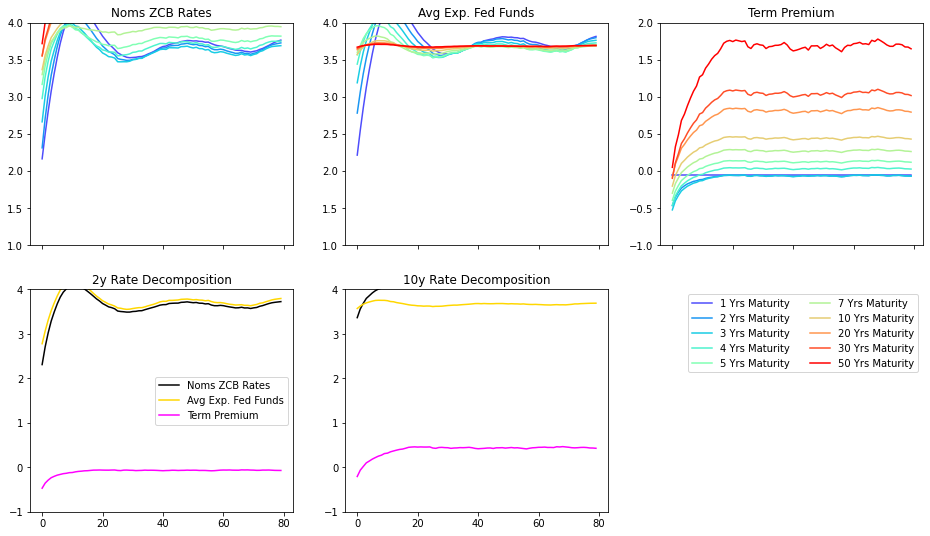

In [19]:
F_PlotRates2(M_avgFFPaths, xp.mean(A_FFPaths, axis=2), Ratestitle = "Noms ZCB Rates", avgPathtitle = "Avg Exp. Fed Funds")

### 4. Compute Inflation Risk Premia

Illustrate IRP, Real Rates, and Expected Inflation

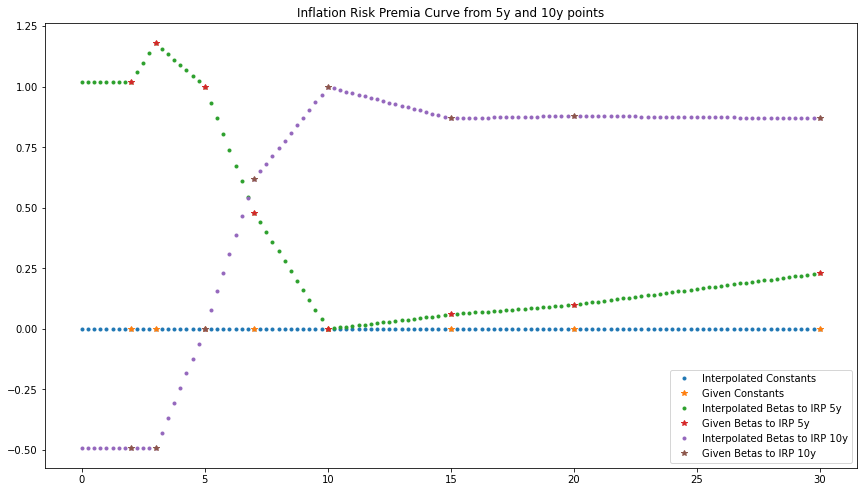

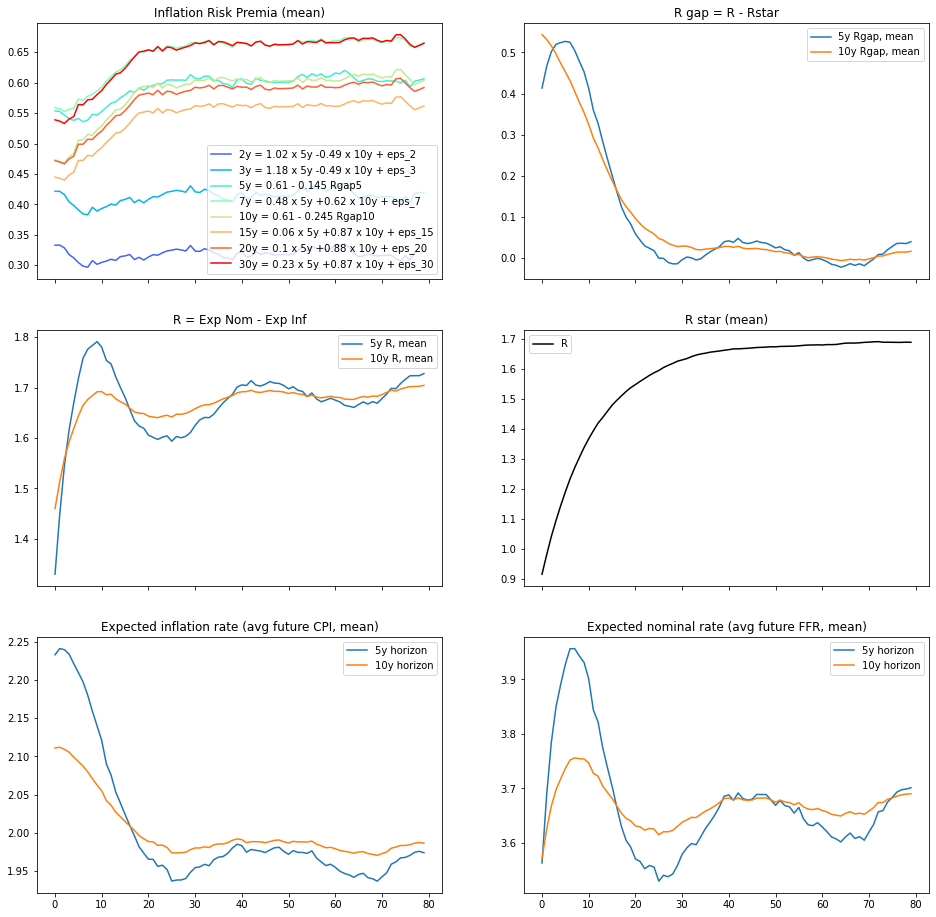

In [20]:
A_StoreIRP = F_MakeIRP(A_ExpFFR_05_10, A_SimSta, A_CPIPaths, plot_IRPcoeff=True, plot_IRP = True)

### 5. Compute TIPS Zero rates, including Liquidity Risk Premia

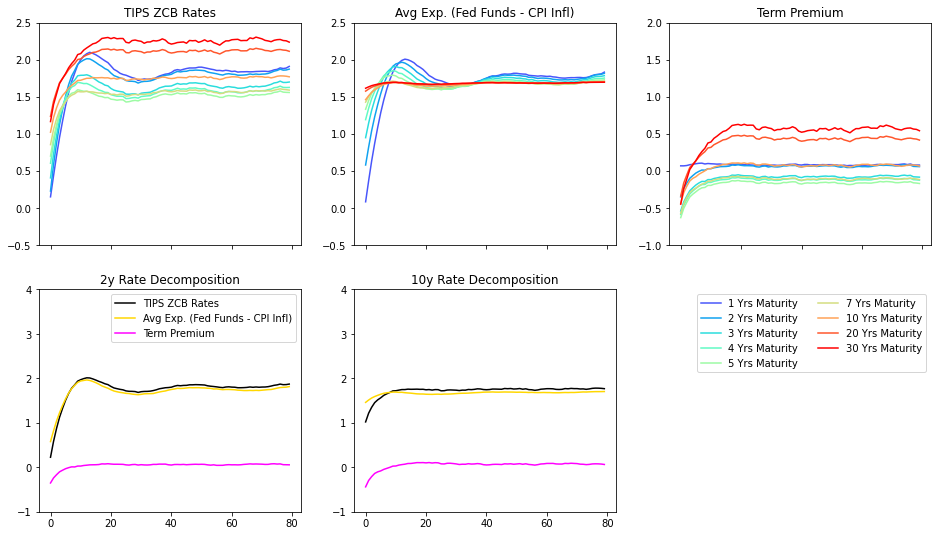

In [21]:
A_StoreIRP *= -1                        # Flip sign:                     Store  =    - IRP
A_StoreIRP += A_FFPaths[:,:30*4+1,:]    # Add nominal yields to -IRP:    Store =  (ExpNom + TP) - IRP
A_StoreIRP -= A_CPIPaths[:,:30*4+1,:];  # Subtract expected inflation:   Store =  (ExpNom + TP) - IRP - ExpCPI
F_addLRP(A_StoreIRP);                   # And add LRP to get tips yield: Store =   ExpNom - ExpCPI + TP - IRP + LRP  = (ExpNom-ExpINF) + (TP - IRP - FRP ) + FRP + LRP =  R + RRP + FRP + LRP = TIPS
F_PlotRates2(M_avgFFPaths[:,:30*4+1] - xp.mean(A_CPIPaths[:,:30*4+1,:], axis=2) , xp.mean(A_StoreIRP, axis=2), Ratestitle = "TIPS ZCB Rates", avgPathtitle = "Avg Exp. (Fed Funds - CPI Infl)", Ylim=[(-.5,2.5),(-.5,2.5),(-1,2)])

### Transform Zero Curves into Par Curves. 

  0%|          | 0/200 [00:00<?, ?it/s]

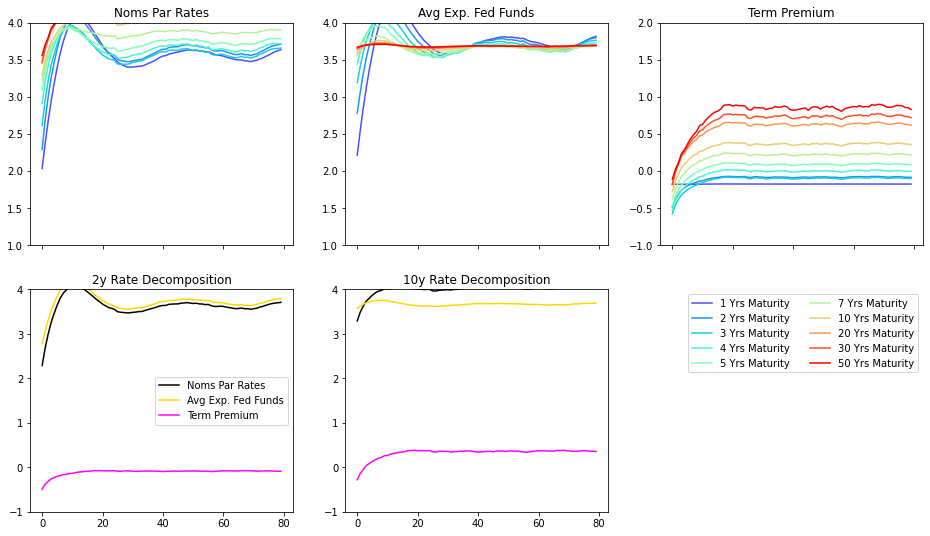

In [22]:
MakeCoupRates(A_FFPaths)
A_FFPaths[:, 0:5, :] -= 0.08  # Adjust par rates for Bill-FFR basis, 8bps in Belton et al., for par rates. 
MakeOnTheRun(A_FFPaths)       # Adjust par rates for on-the run / off-the-run    
F_PlotRates2(M_avgFFPaths, xp.mean(A_FFPaths, axis=2), Ratestitle = "Noms Par Rates", avgPathtitle = "Avg Exp. Fed Funds")

  0%|          | 0/120 [00:00<?, ?it/s]

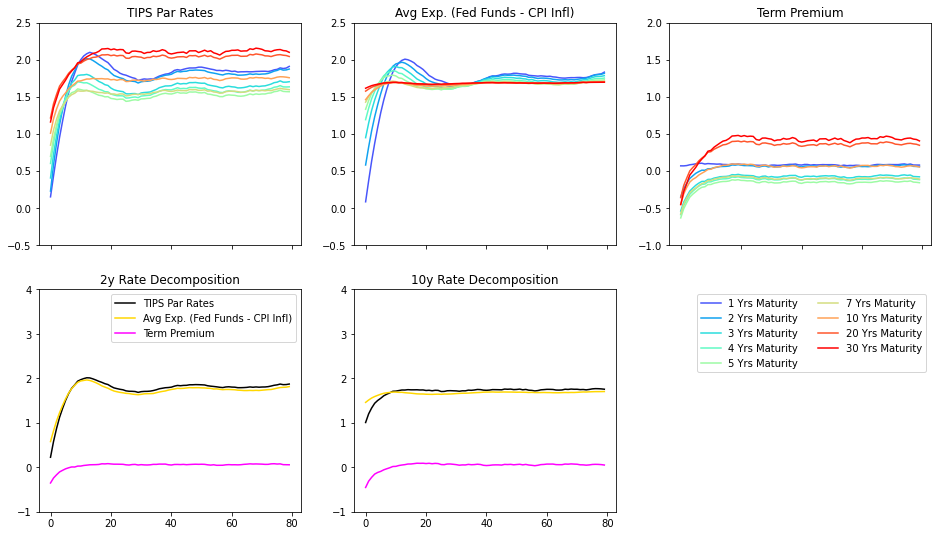

In [23]:
MakeCoupRates(A_StoreIRP); 
F_PlotRates2(M_avgFFPaths[:,:30*4+1] - xp.mean(A_CPIPaths[:,:30*4+1,:], axis=2) , xp.mean(A_StoreIRP, axis=2), Ratestitle = "TIPS Par Rates", avgPathtitle = "Avg Exp. (Fed Funds - CPI Infl)", Ylim=[(-.5,2.5),(-.5,2.5),(-1,2)])

In [24]:
# Delete all storages we used for illustration of intermediate results.
del A_ExpFFR_05_10, A_StoreIRP, M_avgFFPaths, A_FFPaths, A_CPIPaths 

## Rates Block: overall wrapper

In [25]:
A_NomsRates, A_TipsRates, A_FrnsRates = F_SimRat(
    A_SimSta, 
    A_SimObs, 
    ModelMats, 
    plot_rates=False, 
    plot_coeff = False, 
    plot_conv = False, 
    use10y5yslope= D_Setup["use10y5yslope"], 
    use_convadj=D_Setup["use_convadj"], 
    plot_IRPcoeff=False, 
    plot_IRP = False, 
    estimate_not_assume=D_Setup["estimate_not_assume"], 
    replicateBeltonTP=D_Setup["replicateBeltonTP"])

MakeFFPaths3


  0%|          | 0/200 [00:00<?, ?it/s]

MakeTPPaths2
Make IRP


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

## Supply Effects

### Tool to Compute Ratio of Durations of Par Bonds to 10y Par Bond Duration
Use rates to infer duration of nominal par bonds, then take ratio to 10y tenor.
For TIPS, for each maturity, scale the duration ratio of nominal bonds by the beta of the changes in tips par rate to changes in nominal par rate  of same maturity

Illustrate functions

In [26]:
TYE_ratio_Noms, Nom_10yDur  = F_Conversion_TYE(A_NomsRates)
TYE_ratio_Tips, Tip_10yDur  = F_Conversion_TYE(A_TipsRates)
NomsBetasToNom10y, TipsBetasToNom10y, TipsBetasToNoms = F_TipsNomsBetas(A_NomsRates, A_TipsRates)
if xp != np: TYE_ratio_Noms, Nom_10yDur, TYE_ratio_Tips, Tip_10yDur, NomsBetasToNom10y, TipsBetasToNom10y, TipsBetasToNoms = TYE_ratio_Noms.get(), Nom_10yDur.get(), TYE_ratio_Tips.get(), Tip_10yDur.get(), NomsBetasToNom10y.get(), TipsBetasToNom10y.get(), TipsBetasToNoms.get()


### Unadjusted Duration ratio (Conversion currently used)

Plot conversion assuming parallel shift of nominal curve: use simple duration ratio for nominals, and map tips to nominals with beta to same maturity. 

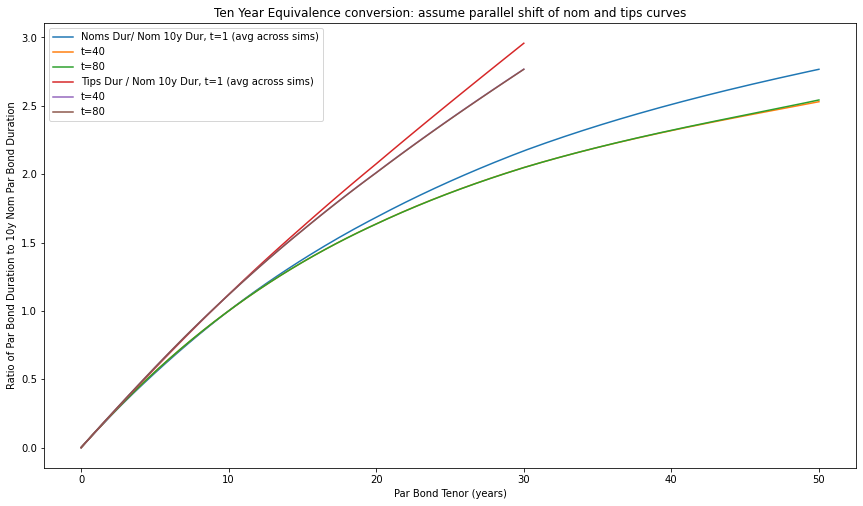

In [27]:
fig1 = plt.figure(figsize=[16/1.1, 9/1.1]) 
Tenor_q  = np.reshape(np.arange(0,50.25,0.25, dtype=np.float32), (-1,1))
PeriodsToPlot = [1,int(D_Setup["n_period"]/2), D_Setup["n_period"]-1]     
plt.plot( Tenor_q , xp.mean(TYE_ratio_Noms[PeriodsToPlot,:,:], axis=2).T ); 
#TYE_ratio_Tips_to_Nom = TYE_ratio_Noms[:,:TipsBetasToNoms.shape[0],:]*np.expand_dims(TipsBetasToNoms/TipsBetasToNoms[4*10], axis=(0,2)) 
TYE_ratio_Tips_to_Nom = ((TYE_ratio_Tips*Tip_10yDur)/Nom_10yDur)  
plt.plot( Tenor_q[:TipsBetasToNoms.shape[0]], xp.mean(TYE_ratio_Tips_to_Nom[PeriodsToPlot,:,:], axis=2).T  ); 
plt.legend(('Noms Dur/ Nom 10y Dur, t=1 (avg across sims)','t=' + str(int(D_Setup["n_period"]/2)),'t=' + str(D_Setup["n_period"]), 'Tips Dur / Nom 10y Dur, t=1 (avg across sims)','t=' + str(int(D_Setup["n_period"]/2)),'t=' + str(D_Setup["n_period"])), loc='best'); 
plt.xlabel('Par Bond Tenor (years)'); 
plt.ylabel('Ratio of Par Bond Duration to 10y Nom Par Bond Duration'); 
plt.title('Ten Year Equivalence conversion: assume parallel shift of nom and tips curves'); 
 


### Adjusted Duration Ratio (alternative conversion method, not used mow)

Plot conversion considering "Hedge Ratio" to 10y Nominal Bond

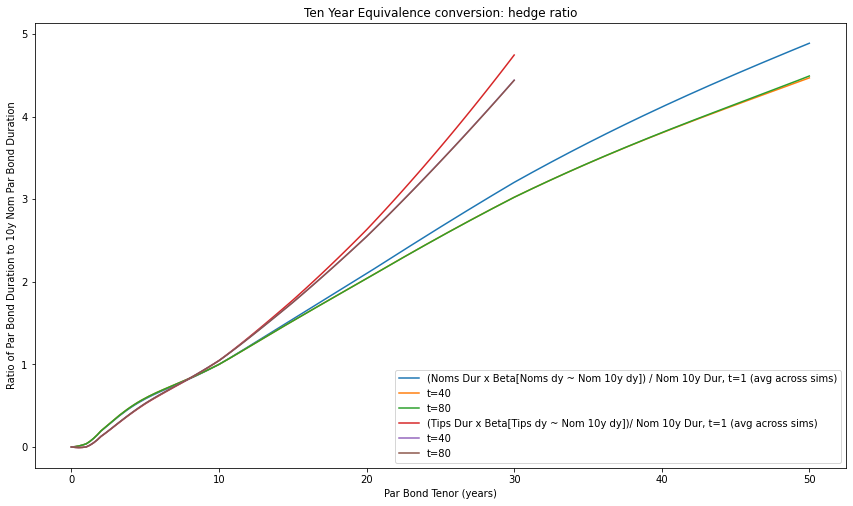

In [28]:
fig2 = plt.figure(figsize=[16/1.1, 9/1.1]) 
TYE_ratio_Tips_to_Nom = ((TYE_ratio_Tips*Tip_10yDur)/Nom_10yDur)                        
plt.plot( Tenor_q , xp.mean(TYE_ratio_Noms[PeriodsToPlot,:,:]*np.expand_dims(NomsBetasToNom10y, axis=(0,2)), axis=2).T ); 
plt.plot( Tenor_q[:TipsBetasToNoms.shape[0]], xp.mean(TYE_ratio_Tips_to_Nom[PeriodsToPlot,:,:]*np.expand_dims(TipsBetasToNom10y, axis=(0,2)) , axis=2).T  ); 
plt.legend(('(Noms Dur x Beta[Noms dy ~ Nom 10y dy]) / Nom 10y Dur, t=1 (avg across sims)','t=' + str(int(D_Setup["n_period"]/2)),'t=' + str(D_Setup["n_period"]), '(Tips Dur x Beta[Tips dy ~ Nom 10y dy])/ Nom 10y Dur, t=1 (avg across sims)','t=' + str(int(D_Setup["n_period"]/2)),'t=' + str(D_Setup["n_period"])), loc='best'); 
plt.xlabel('Par Bond Tenor (years)'); 
plt.ylabel('Ratio of Par Bond Duration to 10y Nom Par Bond Duration'); 
plt.title('Ten Year Equivalence conversion: hedge ratio'); 



In [29]:
del Tenor_q, TYE_ratio_Tips_to_Nom, TYE_ratio_Noms, Nom_10yDur, TYE_ratio_Tips, Tip_10yDur, NomsBetasToNom10y, TipsBetasToNom10y, TipsBetasToNoms

## V) Debt Block
The code is organized as follows:
1. F_InitiProfiles gets at the given start date the profile of outstanding face value and coupon rates for TIPS and Nominal securities at all tenors
2. MakeGDPPaths creates the path of GDP fron Init_GDP and the simulated paths of G, UGAP, PI.
3. F_MakeDebtStorages creates storage arrays needed in the main debt block loop.
4. F_MakeRateStorages creates views of the rates arrays and related indexes needed in the main debt loop.
5. MakeDbtPaths1 is the main debt block loop. 


### 1. Get Initial Debt Profiles (Face Values and Coupon Rates)

Calibrate initial Debt and Average Coupon Rates Profile across tenors. 
Notice that there are no FRNs in the dataset... Their initial Face Values are set to zero.


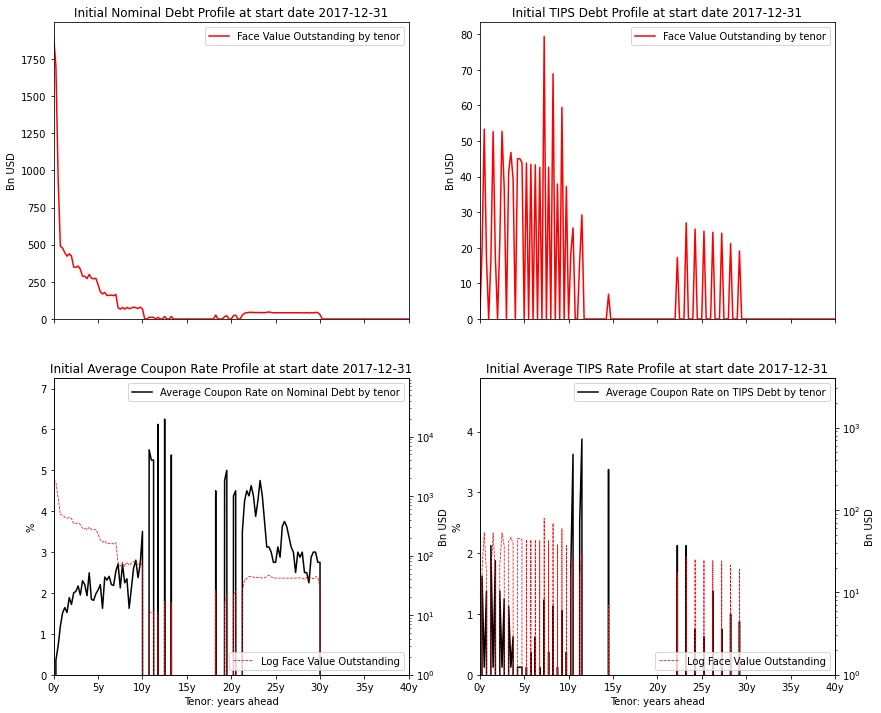

In [30]:
Init_DebtProfiles = F_InitiProfiles(D_Setup["start_year"],D_Setup["start_quarter"], D_Setup["No_TIPS_FRN"], D_Setup["n_exp_horizon"],
                                    path_CRSP=None, plotFigs=True)
#Init_DbtFVout, Init_AvgCoupRate, Init_TipsFVadj, Init_FrnsFV = Init_DebtProfiles

Alternative using MSPD (also has inflation adjustment and floating rate notes):

Use Function:

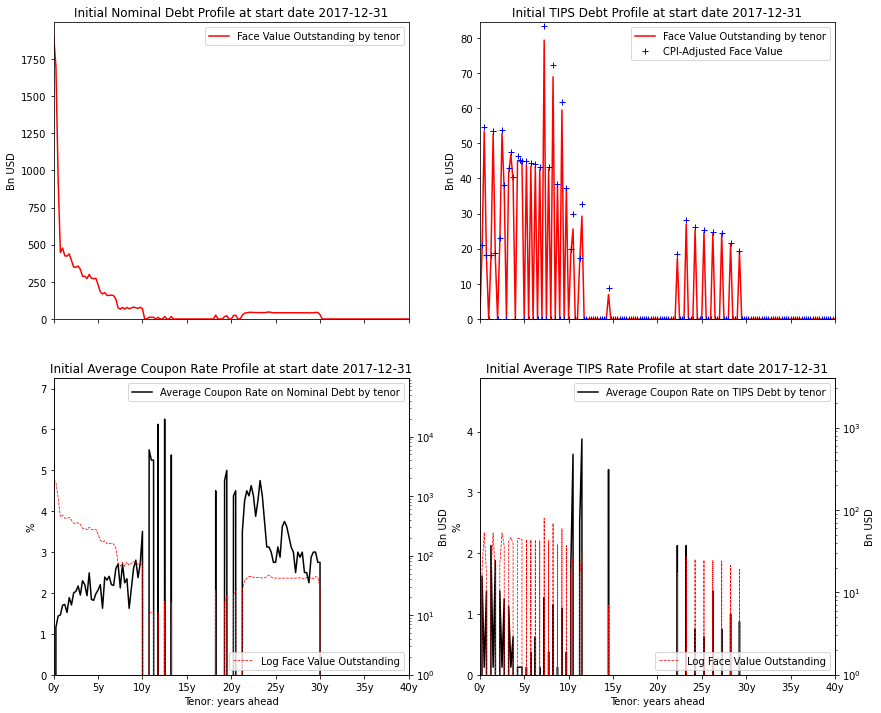

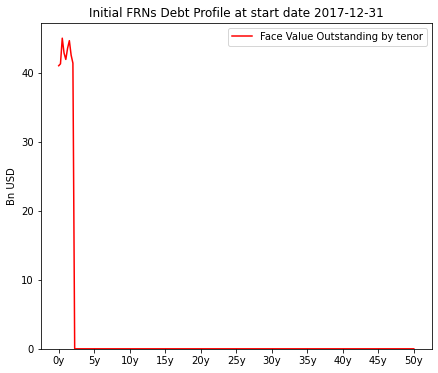

In [31]:
Init_DebtProfiles = F_InitiProfilesMSPD(D_Setup["start_year"],D_Setup["start_quarter"], D_Setup["No_TIPS_FRN"], D_Setup["n_exp_horizon"],
                                    path_MSPD=None, plotFigs=True)

### 2. Create paths of GDP

In [32]:
A_NGDP = MakeGDPPaths(Init_GDP, A_SimSta)

### 3. Create debt storage arrays

In [33]:
DebtStorages = F_MakeDebtStorages(D_Setup["n_period"],D_Setup["n_exp_horizon"],D_Setup["n_simula"])

### 4. Create rate views and index arrays

In [34]:
RateStorages = F_MakeRateStorages(D_Setup["Securities"], A_NomsRates, A_TipsRates, A_FrnsRates)# Pre-slices Rates arrays, creates some indexes. 

### 5. Main Debt Block Loop

## VI) Baseline Strategy Simulation

In [35]:
# Reshape Baseline Kernel into Strategy with shape n_period x n_securities x n_simula
IssuanceStrat = xp.tile(
    xp.expand_dims(D_Setup["Kernel1_Baseline"],0), 
    (D_Setup["n_period"],1,D_Setup["n_simula"]))  

# Compute Debt Block with Baseline Strategy

MakeDbtPaths1(
    *Init_DebtProfiles, 
    IssuanceStrat, 
    *RateStorages, 
    A_SimObs, 
    A_NGDP, 
    *list(DebtStorages.values()), 
    TrackTYEDebt = True,  #Just to keep Track of TYE debt, creating a baseline for it...
    TrackWAM=True, 
    Dynamic = False, 
    QuartersperCoup=D_Setup["QuartersperCoup"],
    n_exp_horizon = D_Setup["n_exp_horizon"],
)

# In case supply effects are to be used with non-baseline strategies, keep track of baseline TYE Debt/GDP:
if D_Setup["Supply_Effects"] == True:
    baselineDebtTYE_GDP = DebtStorages['DebtTYE']/A_NGDP
else: 
    baselineDebtTYE_GDP = None

  0%|          | 0/80 [00:00<?, ?it/s]

Plot results as in Belton et al Fig 4: prepare fuction for plotting...

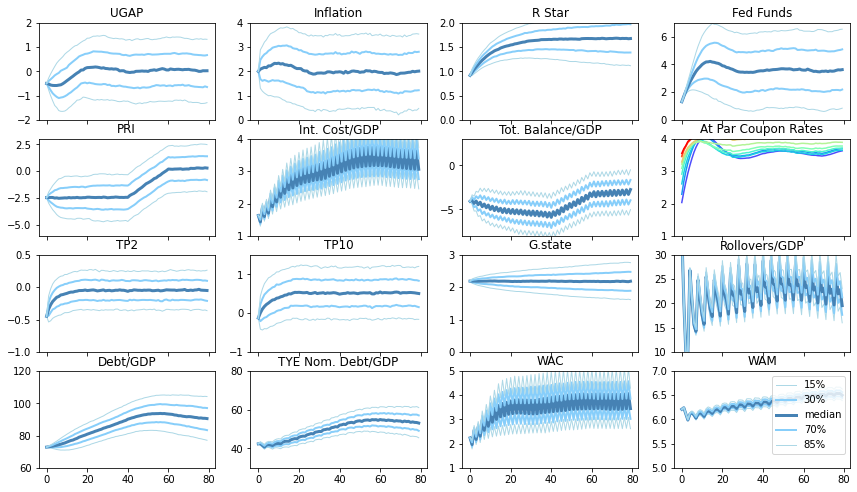

In [36]:
PlotSims2(A_SimObs, A_SimSta, A_NomsRates, 
          DebtStorages['A_IRCost'], DebtStorages['A_DbtSvc'], DebtStorages['A_TotDfc'], DebtStorages['TotDebt'], 
          DebtStorages['WAM'], A_NGDP, DebtStorages['DebtTYE'])

## VII)  Strategies Performance Evaluation
The code is organized as follows:  

0. Tools:
    * A) Performance is a function that, given a set of strategies (static or dynamic), calls the debt block on each of them, and computes performance statistics. 
    * B) PlotStrats is a function that plots the results from Performance, both as cost-risk frontiers plot and tabulating the statistics. 
1. Use the tools above on Static single-security strategies
2. Use the tools above on Static kernel-mixture issuance strategies
3. Use the tools above on Dynamic issuance strategy

### 0. Tools

#### A) Function to Compute Performance Statistics

#### B) Function to plot Performance Statistics

### 1. Static single-security issuance strategies
Replicate Figure 5: Performance of single security issuance strategies (and baseline) 

#### A) Compute performance of single-security issuance strategies

In [37]:
Avg_IssRate, Avg_IRCost, Std_IRCost, Std_TotBal, Cor_IRC_PRI =  Performance(
    Init_DebtProfiles, 
    RateStorages, 
    A_SimObs, 
    A_NGDP, 
    Securities = D_Setup["Securities"], 
    SingleIssuance = True, 
    QuartersperCoup=D_Setup["QuartersperCoup"],
    n_period=D_Setup["n_period"],
    n_exp_horizon=D_Setup["n_exp_horizon"],
    n_simula=D_Setup["n_simula"],
)

  0%|          | 0/15 [00:00<?, ?it/s]

#### B) Figure: Single-Security Issuance Strategies

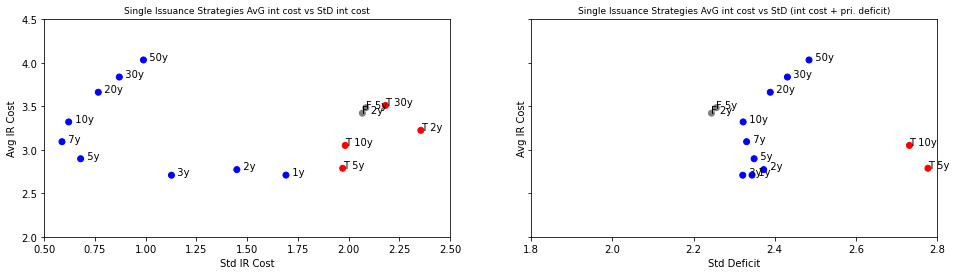

In [38]:
StratNames = [ ['  ','T ', 'F '][int(s)] + str(t) + 'y' for s,t in zip(D_Setup["Securities"][0,:], D_Setup["Securities"][1,:] ) ]
ColorList =  [ ['blue','red', 'gray'][int(s)]  for s in  D_Setup["Securities"][0,:] ]
TipsandFRN = max(D_Setup["Securities"][0,:]) > 0
table1 = PlotStrats(
    Avg_IssRate, Avg_IRCost,Std_IRCost,Std_TotBal, 
    Cor_IRC_PRI, 'Single Issuance Strategies', 
    StratNames=StratNames, 
    Y_lim=(2,4.5) , X_lim=(0+0.5*TipsandFRN,2+0.5*TipsandFRN), 
    XX_lim=(1+0.8*TipsandFRN,3-0.2*TipsandFRN), ColorList=ColorList)

#### C) Table: Single Security Issuance Strategies

In [39]:
table1

,1y,2y,3y,5y,7y,10y,20y,30y,50y,T 2y,T 5y,T 10y,T 30y,F 2y,F 5y
Average Issuance Rate,3.63,3.71,3.66,3.78,3.90,4.05,4.31,4.41,4.52,1.89,1.58,1.75,2.09,3.90,4.06
Average IR Cost/GDP,2.71,2.77,2.71,2.90,3.09,3.32,3.66,3.84,4.03,3.22,2.79,3.05,3.51,3.42,3.48
StDev IR Cost/GDP,1.69,1.45,1.13,0.68,0.59,0.62,0.77,0.87,0.99,2.36,1.97,1.98,2.18,2.07,2.09
StDev (IR Cost/GDP + PRI Deficit/GDP),2.34,2.37,2.32,2.35,2.33,2.32,2.39,2.43,2.48,2.92,2.78,2.73,2.87,2.24,2.26
"Corr (IRCost/GDP , PRI Deficit/GDP)",-0.26,-0.16,-0.08,0.18,0.23,0.18,0.18,0.17,0.16,-0.15,-0.08,-0.12,-0.11,-0.43,-0.43


### 2. Static kernel-mixture issuance strategies
Replicate Figure 6: Performance of static mixture of kernels strategies

#### A) Compute performance of static kernel-mixture issuance strategies

In [40]:
# Prepare strategies as mixture of Kernels. 
N_StratVary = 20 # This controls how fine the mixing of kernels is. 
#M_Kernels = xp.concatenate(
#    (D_Setup["Kernel1_Baseline"] ,D_Setup["Kernel2_Bills"], D_Setup["Kernel3_Belly"], D_Setup["Kernel4_Bonds"]),
#    axis=1)
Const = xp.ones((D_Setup["n_period"],1, D_Setup["n_simula"]),dtype=xp.float32)
#CoeffstoConst = xp.zeros((D_Setup["M_Kernels"].shape[1],1,N_StratVary*3+1), dtype=xp.float32); # Loading on each Kernel (or rows) for the value of Const and MeVs (on columns)
#weight_K1 = 1
#for s in range(N_StratVary*3+1):
#    weight_K2 = (s>= 0*N_StratVary)*(s<1*N_StratVary)*(-0.4  +((s-0*N_StratVary)/(N_StratVary-1))*(0.5  - (-0.4 )))
#    weight_K3 = (s>= 1*N_StratVary)*(s<2*N_StratVary)*(-0.08 +((s-1*N_StratVary)/(N_StratVary-1))*(0.1  - (-0.08)))
#    weight_K4 = (s>= 2*N_StratVary)*(s<3*N_StratVary)*(-0.0  +((s-2*N_StratVary)/(N_StratVary-1))*(0.25 - (-0.0 )))
#    CoeffstoConst[:,0,s] = xp.array([weight_K1, weight_K2,weight_K3 , weight_K4], dtype=xp.float32)             # Set Coefficients to Constant Only.
CoeffstoConst = xp.zeros((D_Setup["M_Kernels"].shape[1],1,N_StratVary*len(D_Setup["L_KernelNames"]) +1), dtype=xp.float32); # Loading on each Kernel (or rows) for the value of Const and MeVs (on columns)
for s in range(N_StratVary*len(D_Setup["L_KernelNames"])+1):  # Index over strategies. 
    CoeffstoConst[0,0,s] = 1                                  # Weight of baseline kernel in each strategy
    for k in range(len(D_Setup["L_KernelNames"])):            # Weight of other kernels in each strategy
        CoeffstoConst[1+k,0,s] = (s>= k*N_StratVary)*(s<(k+1)*N_StratVary)*(D_Setup["L_KernelBounds"][k][0]  +((s-k*N_StratVary)/(N_StratVary-1))*(D_Setup["L_KernelBounds"][k][1]  - D_Setup["L_KernelBounds"][k][0])) 

    
# Compute performance of strategies
Avg_IssRate, Avg_IRCost, Std_IRCost, Std_TotBal, Cor_IRC_PRI =  Performance(
    Init_DebtProfiles, 
    RateStorages, 
    A_SimObs, 
    A_NGDP, 
    Securities = D_Setup["Securities"], 
    Const_and_MEVs=Const,  
    M_Kernels=D_Setup["M_Kernels"], 
    CoeffstoConst_and_MEVs=CoeffstoConst, 
    Static=True, 
    QuartersperCoup=D_Setup["QuartersperCoup"],
    n_period=D_Setup["n_period"],
    n_exp_horizon=D_Setup["n_exp_horizon"],
    n_simula=D_Setup["n_simula"]
)

  0%|          | 0/81 [00:00<?, ?it/s]

#### B) Figure: plot performance of static kernel-mixture issuance strategies

,,,,,,,,,,,...,,,,,,,,,More,Basel
Average Issuance Rate,3.84,3.83,3.82,3.81,3.80,3.79,3.78,3.77,3.76,3.75,...,3.55,3.53,3.51,3.49,3.48,3.46,3.44,3.42,3.40,3.75
Average IR Cost/GDP,3.17,3.16,3.16,3.15,3.14,3.13,3.12,3.11,3.10,3.09,...,3.16,3.17,3.17,3.18,3.18,3.19,3.19,3.20,3.20,3.10
StDev IR Cost/GDP,0.56,0.56,0.56,0.57,0.57,0.58,0.59,0.60,0.61,0.63,...,0.70,0.72,0.73,0.74,0.75,0.76,0.78,0.79,0.80,0.62
StDev (IR Cost/GDP + PRI Deficit/GDP),2.26,2.25,2.25,2.24,2.24,2.23,2.22,2.22,2.21,2.20,...,2.20,2.21,2.21,2.21,2.21,2.21,2.22,2.22,2.22,2.21
"Corr (IRCost/GDP , PRI Deficit/GDP)",0.11,0.10,0.09,0.08,0.06,0.05,0.03,0.02,-0.00,-0.02,...,-0.05,-0.06,-0.06,-0.06,-0.06,-0.06,-0.07,-0.07,-0.07,-0.01


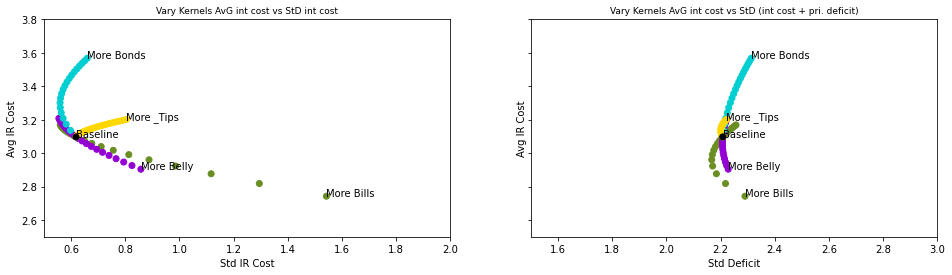

In [41]:
ColorPalette = ['olivedrab', 'darkviolet', 'darkturquoise', 'gold', 'salmon', 'firebrick','silver','blue']
ColorList = [ColorPalette[k] for k in range(len(D_Setup["L_KernelNames"])) for x in range(N_StratVary) ] + ['black']

#ColorList = ['olivedrab' for x in range(N_StratVary)] + ['darkviolet' for x in range(N_StratVary)] + ['aquamarine' for x in range(N_StratVary)] + ['black']
StratNames = ['' for x in range(len(D_Setup["L_KernelNames"])*N_StratVary)] + ['Baseline']
for k in range(len(D_Setup["L_KernelNames"])):
    StratNames[(k+1)*N_StratVary-1] = 'More ' + D_Setup["L_KernelNames"][k][max(0,len(D_Setup["L_KernelNames"][k])-5):]
#StratNames[N_StratVary-1] = 'More Bills'; 
#StratNames[2*N_StratVary-1] = 'More Belly'; 
#StratNames[3*N_StratVary-1] = 'More Bonds'
PlotStrats(Avg_IssRate, Avg_IRCost,Std_IRCost,Std_TotBal, Cor_IRC_PRI, 'Vary Kernels', ColorList=ColorList, StratNames=StratNames, Y_lim=(2.5,3.8) , X_lim=(0.5,2), XX_lim=(1.5,3), Tabulate=True)

#### C) Supply Effects: if asked, compute performance of static kernel-mixture with supply effects


In [42]:
# Compute performance of strategies with supply feedback
if D_Setup["Supply_Effects"] == True:
    Avg_IssRateS, Avg_IRCostS, Std_IRCostS, Std_TotBalS, Cor_IRC_PRIS =  Performance(
        Init_DebtProfiles, 
        RateStorages, 
        A_SimObs, 
        A_NGDP, 
        Securities = D_Setup["Securities"], 
        Const_and_MEVs=Const,  
        M_Kernels=D_Setup["M_Kernels"], 
        CoeffstoConst_and_MEVs=CoeffstoConst, 
        Static=True, 
        QuartersperCoup=D_Setup["QuartersperCoup"],
        n_period=D_Setup["n_period"],
        n_exp_horizon=D_Setup["n_exp_horizon"],
        n_simula=D_Setup["n_simula"],
        TrackTYEDebt = D_Setup["Supply_Effects"], #Track TYE Debt only if asked to compute Supply Effects. 
        SupplyEffects = D_Setup["Supply_Effects"],
        baselineDebtTYE_GDP = baselineDebtTYE_GDP,
    )

  0%|          | 0/81 [00:00<?, ?it/s]

Plot as in Belton et al Fig 17:


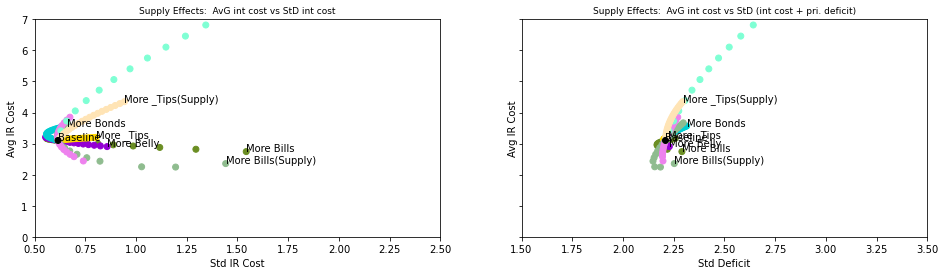

In [43]:
if D_Setup["Supply_Effects"] == True:
    ColorPaletteS = ['darkseagreen', 'violet', 'aquamarine', 'moccasin', 'mistyrose', 'lightcoral','gainsboro','skyblue']
    ColorListS = [ColorPaletteS[k] for k in range(len(D_Setup["L_KernelNames"])) for x in range(N_StratVary) ] + ['black']
    #ColorListS = ['darkseagreen' for x in range(N_StratVary)] + ['lightslategray' for x in range(N_StratVary)] + ['darkslategray' for x in range(N_StratVary)] + ['black']
    StratNamesS = ['' for x in range(len(D_Setup["L_KernelNames"])*N_StratVary)] + ['']
    for k in range(len(D_Setup["L_KernelNames"])):
        StratNamesS[(k+1)*N_StratVary-1] = 'More ' + D_Setup["L_KernelNames"][k][max(0,len(D_Setup["L_KernelNames"][k])-5):] + '(Supply)'
    #StratNamesS = ['' for x in range(3*N_StratVary)]  + ['Baseline']
    #StratNamesS[N_StratVary-1] = 'Bills (Supply)'
    #StratNamesS[2*N_StratVary-1] = 'Belly (Supply)'
    #StratNamesS[3*N_StratVary-1] = 'Bonds (Supply)'
    
    PlotStrats(xp.append(Avg_IssRate, Avg_IssRateS), xp.append(Avg_IRCost,Avg_IRCostS),xp.append(Std_IRCost,Std_IRCostS),xp.append(Std_TotBal,Std_TotBalS), xp.append(Cor_IRC_PRI,Cor_IRC_PRIS), 'Supply Effects: ', ColorList=ColorList+ColorListS, StratNames=StratNames+StratNamesS, Y_lim=(0,7) , X_lim=(0.5,2.5), XX_lim=(1.5,3.5), M_style='o', Tabulate=False)

Plot with larger bounds:

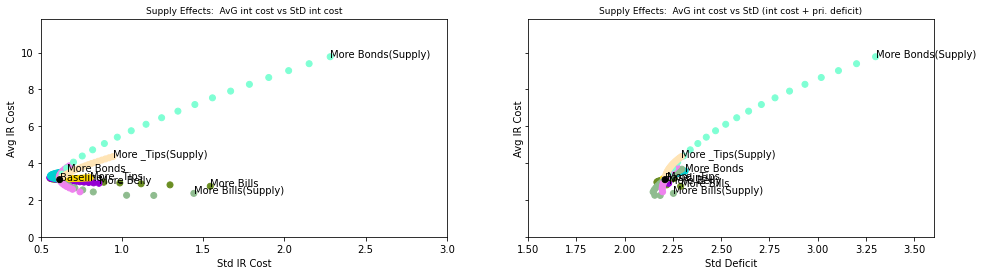

In [44]:
if D_Setup["Supply_Effects"] == True:
    PlotStrats(xp.append(Avg_IssRate, Avg_IssRateS), xp.append(Avg_IRCost,Avg_IRCostS),xp.append(Std_IRCost,Std_IRCostS),xp.append(Std_TotBal,Std_TotBalS), xp.append(Cor_IRC_PRI,Cor_IRC_PRIS), 'Supply Effects: ', ColorList=ColorList+ColorListS, StratNames=StratNames+StratNamesS, Y_lim=(0,11.8) , X_lim=(0.5,3), XX_lim=(1.5,3.6), M_style='o', Tabulate=False)  

### 3. Static Optimization

Illustrate Loss function. Notice that we are not passing permanent storage space to store the more detailed performance stats, but we could have done so, and will do so when computing the frontier

In [45]:
F_Loss(xp.random.uniform(-0.5,0.5,len(D_Setup["L_KernelNames"])), # Example of weights on other Kernels for static strategy
         D_Setup["M_Kernels"],                        # Strategy Kernels on which weights are applied
         Lambda = 1,                                  # Risk Aversion
         Init_DebtProfiles = Init_DebtProfiles , 
         RateStorages = RateStorages,
         A_SimObs=A_SimObs,
         A_NGDP = A_NGDP, 
         D_Setup = D_Setup,
         Risk="Std_IRCost")                           # Option to define risk: Std_IRCost or  Std_TotBal

array([4.5987225], dtype=float32)

Compute static frontier minimizing Loss function.
1. Minimization algorithm is COBYLA, which, like Powell or Nelder-Mead, and unlike SLSQP and L-BFGS-B, does not rely on gradient or hessian computations. Methods relying on derivatives get stuck immediately.
2. Contraints are automatically imposed on kernel weights so that no security can have negative issuance

In [46]:
Avg_IssRateZ, Avg_IRCostZ, Std_IRCostZ, Std_TotBalZ, Cor_IRC_PRIZ, Risk_Aversion = F_StaticOptim(Init_DebtProfiles, 
         RateStorages,
         A_SimObs,
         A_NGDP, 
         D_Setup,
         D_Setup["M_Kernels"],                                                                         
         bnds = [[-2, 2] for x in range(len(D_Setup["L_KernelNames"]))], # Bounds on weights of Kernels
         RA_low=0.0, RA_hig=5, RA_num=11,   # Min and Max Risk Aversion, and number of points in between, in exponentially spaced grid. 
         Risk="Std_TotBal")

  0%|          | 0/11 [00:00<?, ?it/s]

Risk Aversion 0.0
     fun: 2.841198682785034
   maxcv: -0.0
 message: 'Optimization terminated successfully.'
    nfev: 26
  status: 1
 success: True
       x: array([-4.30060798e-01,  1.79756735e-01, -3.87662888e-02,  8.58267824e-18])
Risk Aversion 0.05
     fun: 2.9549169540405273
   maxcv: 2.148261256284424e-18
 message: 'Optimization terminated successfully.'
    nfev: 26
  status: 1
 success: True
       x: array([-4.30060798e-01,  1.79756735e-01, -3.87662888e-02, -8.59304542e-18])
Risk Aversion 0.08
     fun: 3.0231479167938233
   maxcv: 5.6554297121219874e-18
 message: 'Optimization terminated successfully.'
    nfev: 26
  status: 1
 success: True
       x: array([-4.30060798e-01,  1.79756735e-01, -3.87662888e-02, -2.26217181e-17])
Risk Aversion 0.14
     fun: 3.038703050613403
   maxcv: 9.080395102500916e-09
 message: 'Optimization terminated successfully.'
    nfev: 39
  status: 1
 success: True
       x: array([5.16497524e-01, 4.21318141e-03, 2.53806975e-03, 8.19621954e-18])

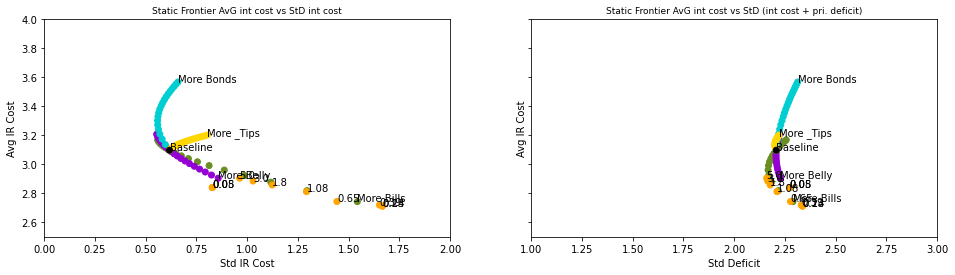

In [47]:
#Plot Performance
RA_num = Risk_Aversion.shape[0]
ColorList = [ColorPalette[k] for k in range(len(D_Setup["L_KernelNames"])) for x in range(N_StratVary) ] + ['black'] + ['orange' for x in range(RA_num)]
StratNames = ['' for x in range(len(D_Setup["L_KernelNames"])*N_StratVary)] + ['Baseline'] + [str(xp.round(Risk_Aversion[x],2)) for x in range(RA_num)]
for k in range(len(D_Setup["L_KernelNames"])):
    StratNames[(k+1)*N_StratVary-1] = 'More ' + D_Setup["L_KernelNames"][k][max(0,len(D_Setup["L_KernelNames"][k])-5):]
table3=PlotStrats(xp.append(Avg_IssRate,Avg_IssRateZ) , xp.append(Avg_IRCost, Avg_IRCostZ) , xp.append(Std_IRCost, Std_IRCostZ) , xp.append(Std_TotBal, Std_TotBalZ), xp.append(Cor_IRC_PRI,Cor_IRC_PRIZ), 'Static Frontier', ColorList=ColorList, StratNames=StratNames, Y_lim=(2.5,4) , X_lim=(0,2), XX_lim=(1,3), Tabulate=True)

In [48]:
table3.iloc[:,len(D_Setup["L_KernelNames"])*N_StratVary+1:] 

,0.0,0.05,0.08,0.14,0.23,0.39,0.65,1.08,1.8,3.0,5.0
Average Issuance Rate,3.73,3.73,3.73,3.64,3.64,3.63,3.64,3.65,3.66,3.67,3.67
Average IR Cost/GDP,2.84,2.84,2.84,2.71,2.71,2.72,2.74,2.81,2.86,2.88,2.90
StDev IR Cost/GDP,0.83,0.83,0.83,1.67,1.67,1.65,1.44,1.29,1.12,1.03,0.96
StDev (IR Cost/GDP + PRI Deficit/GDP),2.27,2.27,2.27,2.34,2.34,2.33,2.28,2.21,2.18,2.17,2.16
"Corr (IRCost/GDP , PRI Deficit/GDP)",-0.01,-0.01,-0.01,-0.26,-0.26,-0.26,-0.23,-0.24,-0.22,-0.20,-0.19


### 4. Dynamic issuance strategy
Replicate Fig 13 and Fig 11 of Belton et al with Dynamic Strategy having Coefficients as in Fig 10

#### A) If ReplicateBelton ==  True, need to re-compute macro block and rates block
This is because Fig 11 and Fig 13 in Belton et al were done with different starting states than the ones for Fig 4.

In [49]:
if D_Setup["ReplicateBelton"] ==  True:   
    del A_SimSta, A_SimObs, A_NomsRates, A_TipsRates, A_FrnsRates, RateStorages, DebtStorages #Free up as much space as possible
    V_StaSrt = np.array([-0.5,1.5,-1.5,1.75,1.15,-0.5,1.5,-1.5,1.75,1.15,0,0,-0.55,0])
    A_SimSta = F_SimSta(D_Setup["n_period"], D_Setup["n_simula"], V_StaSrt, ModelMats) 
    A_SimObs = F_SimObs(A_SimSta, ModelMats,D_Setup["CBO_projection"],D_Setup["CBO_weight"])
    A_NomsRates, A_TipsRates, A_FrnsRates = F_SimRat(A_SimSta, A_SimObs, ModelMats, plot_rates=False, plot_coeff = False, plot_conv = False, use10y5yslope=D_Setup["use10y5yslope"], use_convadj=D_Setup["use_convadj"], plot_IRPcoeff=False, plot_IRP = False, estimate_not_assume=D_Setup["estimate_not_assume"], replicateBeltonTP=True)
    RateStorages = F_MakeRateStorages(D_Setup["Securities"], A_NomsRates, A_TipsRates, A_FrnsRates)
    DebtStorages = F_MakeDebtStorages(D_Setup["n_period"],D_Setup["n_exp_horizon"],D_Setup["n_simula"]) 

#### B) Prepare dynamic strategy defined by MEVs and Coefficients of Kernels to MEVs. 
Coefficients are as in Belton et al Fig 10

In [50]:
# MEVS are: 
Const_and_MEVs  = xp.concatenate((
                                 xp.ones((D_Setup["n_period"],1, D_Setup["n_simula"]),dtype=xp.float32), # Constant, 
                                 (A_NomsRates[:,[2*4],:] - A_SimSta[:,[3],:]),                           # 2y Real Rates, 
                                 A_SimObs[:,[4],:],                                                      # 10y Term Premium
                                 - xp.expand_dims(A_SimObs[:,6,:] * A_NGDP /400, axis=1) ),              # Deficit/GDP (Only PRI here, IRCost will be added in Debt Loop).
                                 axis=1 )  
# Coefficients are:
#CoeffstoConst_and_MEVs =  xp.array([[-279.4 , 255.2, 418.1, -0.6],  # (Non normalized) betas of K2 to Constant and MEVs
#                                    [   70.6,  -6.2,  70.3,  0.3],  # (Non normalized) betas of K3 to Constant and MEVs
#                                    [  -42.3,  25.0,  -5.9, -0.1]]) # (Non normalized) betas of K4 to Constant and MEVs

#### C) Replicate Fig 11: issuance shares under dynamic strategy

In [51]:
UnadjustedKernelIssuance =   D_Setup["M_Kernels"][:,1:]    @  (D_Setup["CoeffstoConst_and_MEVs"] @ Const_and_MEVs)
SumUnadjustedKernelIssuance = xp.sum(UnadjustedKernelIssuance, axis = 1) # Very small quantities, between -0.0000009 and + 0.0000008.
IssuanceStrat = xp.zeros((D_Setup["n_period"],D_Setup["Securities"].shape[1], D_Setup["n_simula"]), dtype = xp.float32)
MakeDbtPaths1(
    *Init_DebtProfiles, IssuanceStrat, *RateStorages, A_SimObs, A_NGDP, 
    *list(DebtStorages.values()), M_Kernels=D_Setup["M_Kernels"], 
    CoeffstoConst_and_MEVs=D_Setup["CoeffstoConst_and_MEVs"], 
    UnadjustedKernelIssuance=UnadjustedKernelIssuance, 
    SumUnadjustedKernelIssuance=SumUnadjustedKernelIssuance,
    TrackWAM= True,
    Dynamic = True, 
    QuartersperCoup=D_Setup["QuartersperCoup"],)
#Tabulate:
if xp != np: X = IssuanceStrat[0,:,0].get(); XX = xp.mean(IssuanceStrat[79,:,:], axis=1).get()
else:        X = IssuanceStrat[0,:,0];       XX = xp.mean(IssuanceStrat[79,:,:], axis=1)
row_names = ["Dynamic Issuance Strategy at Initial MEVs", "Mean Dynamic Issuance Strategy at long-run MEVs"]
SecNames  = [ ['  ','T ', 'F '][int(s)] + str(t) + 'y' for s,t in zip(D_Setup["Securities"][0,:], D_Setup["Securities"][1,:] ) ]
print(' ')
table2 = pd.DataFrame([np.round(X,2), np.round(XX,2)],  row_names, [name[0:4]  for name in SecNames])
table2

  0%|          | 0/80 [00:00<?, ?it/s]

,1y,2y,3y,5y,7y,10,20,30,50,T 2y,T 5y,T 10,T 30,F 2y,F 5y
Dynamic Issuance Strategy at Initial MEVs,0.27,0.18,0.19,0.20,0.09,0.06,0.0,0.02,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Mean Dynamic Issuance Strategy at long-run MEVs,0.54,0.12,0.16,0.14,0.03,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### D) Replicate Fig 13: performance of dynamic strategy

  0%|          | 0/1 [00:00<?, ?it/s]

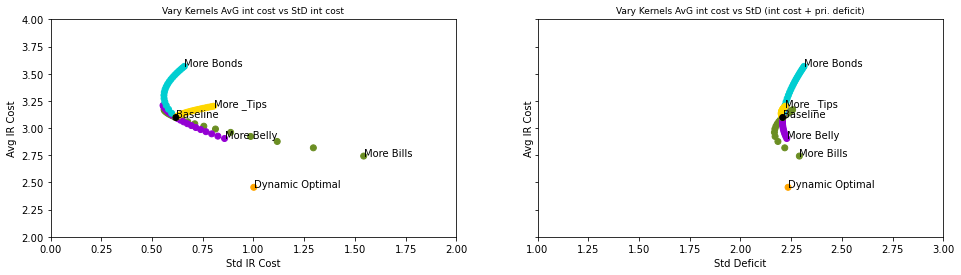

In [52]:
# Compute Strategy performance
Avg_IssRateD, Avg_IRCostD, Std_IRCostD, Std_TotBalD, Cor_IRC_PRID =  Performance(
    Init_DebtProfiles, 
    RateStorages, 
    A_SimObs, 
    A_NGDP, 
    D_Setup["Securities"], 
    Const_and_MEVs=Const_and_MEVs,  
    M_Kernels=D_Setup["M_Kernels"], 
    CoeffstoConst_and_MEVs=xp.expand_dims(D_Setup["CoeffstoConst_and_MEVs"], axis=2), 
    Dynamic=True, 
    QuartersperCoup=D_Setup["QuartersperCoup"],
    n_period=D_Setup["n_period"],
    n_exp_horizon=D_Setup["n_exp_horizon"],
    n_simula=D_Setup["n_simula"],
)

#Plot Performance
ColorList = [ColorPalette[k] for k in range(len(D_Setup["L_KernelNames"])) for x in range(N_StratVary) ] + ['black'] +['orange']
StratNames = ['' for x in range(len(D_Setup["L_KernelNames"])*N_StratVary)] + ['Baseline'] + ['Dynamic Optimal']
for k in range(len(D_Setup["L_KernelNames"])):
    StratNames[(k+1)*N_StratVary-1] = 'More ' + D_Setup["L_KernelNames"][k][max(0,len(D_Setup["L_KernelNames"][k])-5):]
PlotStrats(xp.append(Avg_IssRate,Avg_IssRateD) , xp.append(Avg_IRCost, Avg_IRCostD) , xp.append(Std_IRCost, Std_IRCostD) , xp.append(Std_TotBal, Std_TotBalD), xp.append(Cor_IRC_PRI,Cor_IRC_PRID), 'Vary Kernels', ColorList=ColorList, StratNames=StratNames, Y_lim=(2,4) , X_lim=(0,2), XX_lim=(1,3), Tabulate=False)

In [53]:
print("Elapsed time: ", round(time()-tic,2), " secs")

Elapsed time:  181.71  secs
